In [114]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

array([[list([<matplotlib.lines.Line2D object at 0x000002135B0250A0>])],
       [list([<matplotlib.lines.Line2D object at 0x000002135B0253D0>])]],
      dtype=object)

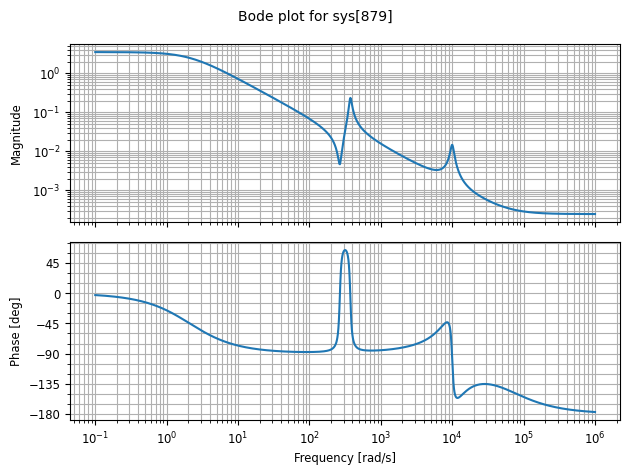

In [115]:

Gf = tf_from_txt(r'tf_txt\Gf.txt')

ctrl.bode(Gf)


In [116]:
Gf

TransferFunction(array([-2.45755575e-04,  1.20077395e+01,  1.20380740e+05,  1.45058965e+09,
        4.06012480e+10,  1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# IMC Controller

In [117]:
# Zeros  of plant

for z in Gf.zeros():

    if z.imag > 0.1:
        w0 = np.sqrt(z.real**2 + z.imag**2)
        zeta = -np.real(z)/w0

        print(f'w0 = {w0}, zeta = {zeta}')
    elif np.abs(z.imag) < 0.1:
        print(f'w0 = {z.real}')


w0 = 58882.66440929401
w0 = 10000.000000779719, zeta = 0.49999999991035293
w0 = 266.36121710633, zeta = 0.04161182519460658


w_cl_m = 439.822971502571


TransferFunction(array([-6.35512621e+09,  3.09978398e+14,  3.13920276e+18,  3.77737032e+22,
        4.20737156e+24,  2.65493330e+27]), array([7.09482980e+12, 7.96856115e+16, 9.28080533e+19, 5.60393615e+22,
       1.71673237e+25, 2.65493330e+27]))

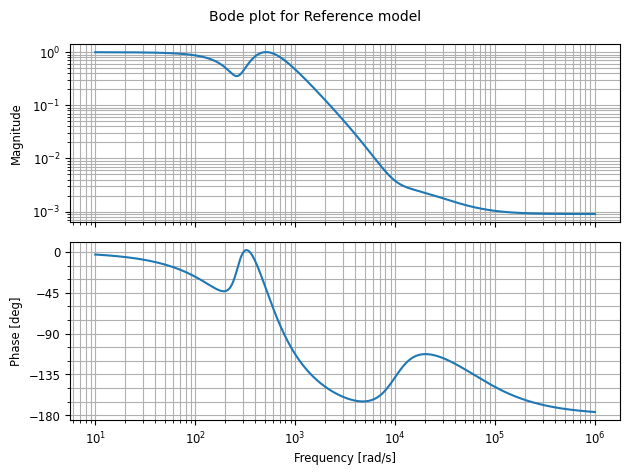

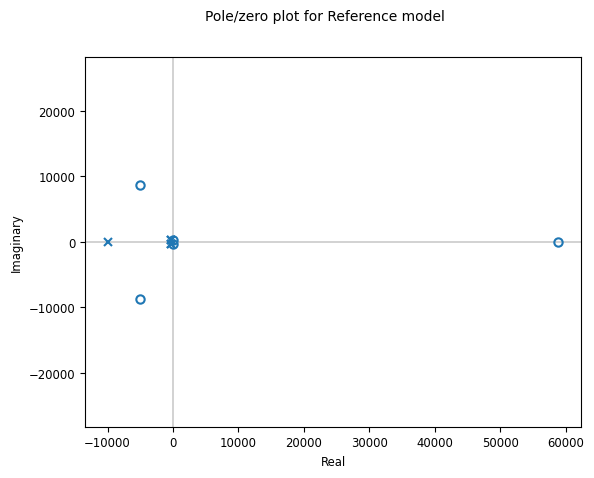

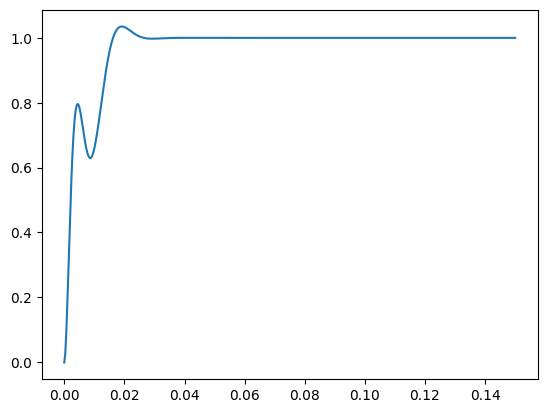

In [124]:


#G_zeros = ctrl.tf(Gf.num[0][0], [0, 1])
G_zeros = 1/pt2(10000.000000779719, zeta = 0.49999999991035293) * 1/pt2(266.36121710633, zeta = 0.2) * (s - 58882.66440929401)

w_cl_m = 70*2*np.pi
print(f'w_cl_m = {w_cl_m}')
M = G_zeros * pt2(w_cl_m, 0.7)**2 * 1/(s/1e4 + 1)

M *= 1/M.dcgain()

# Ref model

M.name = 'Reference model'
ctrl.bode(M)

plt.figure()

ctrl.pzmap(M)

plt.figure()


ts = np.linspace(0,0.15,500)
t,y = ctrl.step_response(M,T=ts)
plt.plot(t,y)

M

8 states have been removed from the model


TransferFunction(array([3.64158104e+00, 4.14924492e+03, 3.65446339e+08, 5.16107959e+10,
       7.81571467e+13, 6.42018204e+15, 3.62595938e+18, 7.57812653e+18]), array([1.00000000e+00, 1.11999687e+04, 1.29460410e+07, 3.64516115e+09,
       2.77794616e+12, 2.22949805e+14, 1.29483537e+17, 0.00000000e+00]))

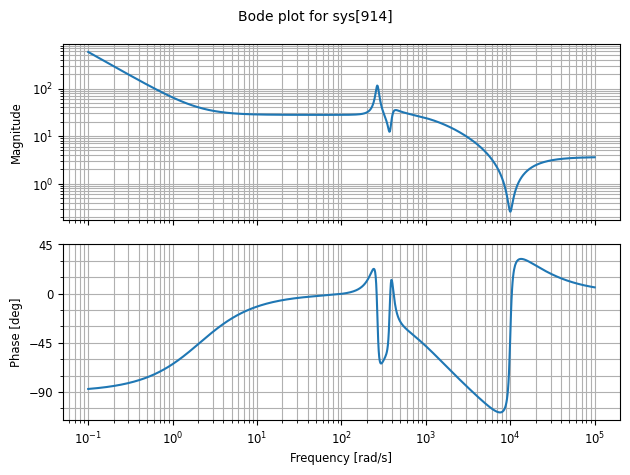

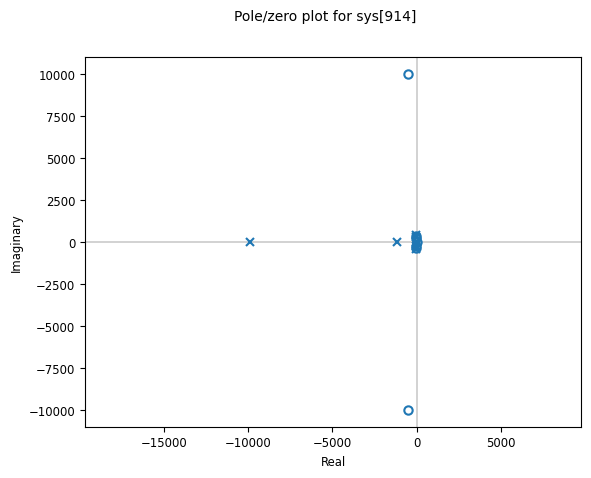

In [119]:
C_imc = M/(1-M) * (1/Gf)
C_imc = ctrl.minreal(C_imc)

ctrl.bode(C_imc)


plt.figure()
ctrl.pzmap(C_imc)

C_imc


In [120]:

with open(r'tf_txt\C_imc.txt','w') as f:
    print_tf(C_imc,f)



7 states have been removed from the model
5 states have been removed from the model


array([[list([<matplotlib.lines.Line2D object at 0x00000213564FA510>])],
       [list([<matplotlib.lines.Line2D object at 0x00000213564FA960>])]],
      dtype=object)

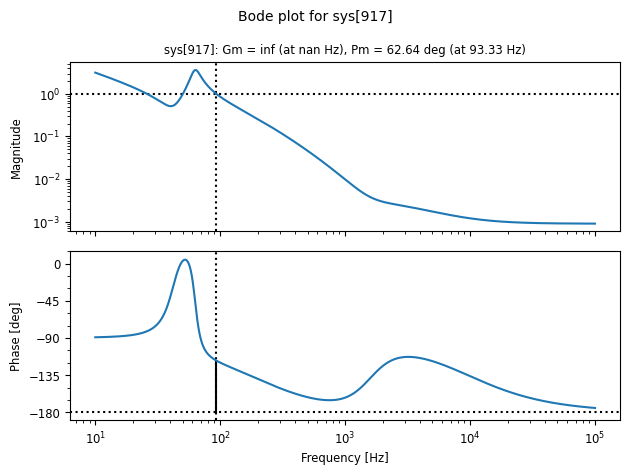

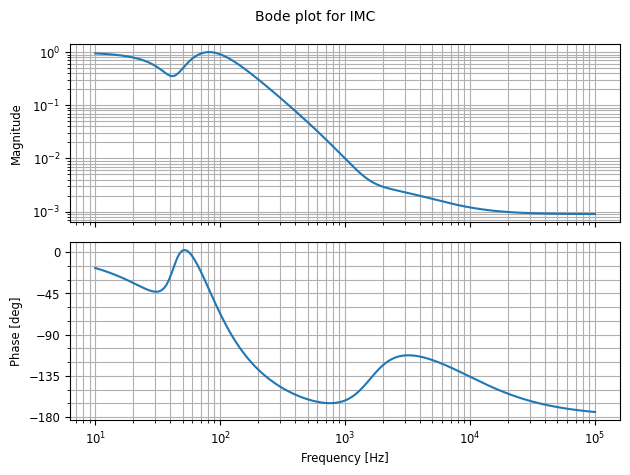

In [121]:
L_imc = C_imc*Gf
L_imc = ctrl.minreal(L_imc)


ctrl.bode(L_imc,display_margins=True,Hz=True)

CL_imc = L_imc/(1+L_imc)
CL_imc = ctrl.minreal(CL_imc)
CL_imc.name = 'IMC'


plt.figure()
ctrl.bode(CL_imc,Hz=True)


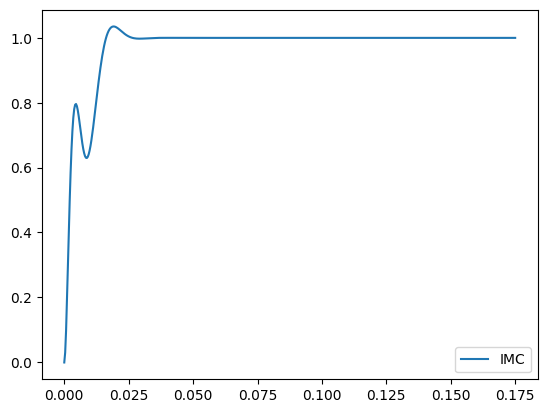

In [122]:
tv = np.linspace(0,0.175,500)

t,y = ctrl.step_response(CL_imc,T=tv)

plt.figure()
plt.plot(t,y)
plt.legend(['IMC','IMC2'])

0 states have been removed from the model


array([[list([<matplotlib.lines.Line2D object at 0x000002135BC2CEC0>])],
       [list([<matplotlib.lines.Line2D object at 0x000002135BC2D010>])]],
      dtype=object)

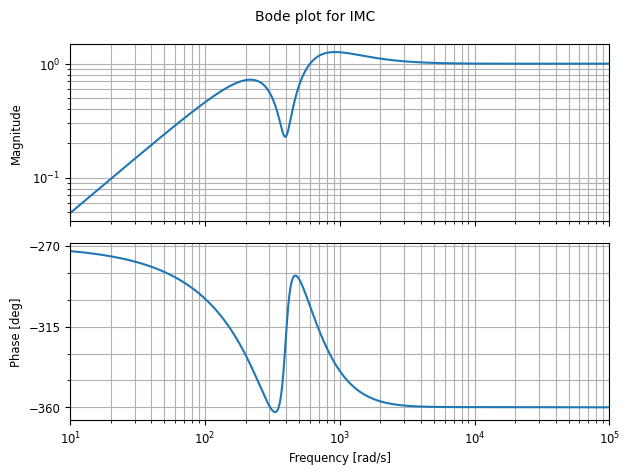

In [123]:


S_imc = 1/(1+L_imc)

S_imc = ctrl.minreal(S_imc)

S_imc.name = 'IMC'

omega_lim = [10,1e5]

ctrl.bode(S_imc,omega_limits=omega_lim)